<a href="https://colab.research.google.com/github/jacKlinc/german_char_recogniser/blob/main/mdl_german_char_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.0MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 1.1MB 16.8MB/s 
     |████████████████████████████████| 194kB 29.9MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
Mounted at /content/gdrive


In [ ]:
from fastai.vision.all import *
from fastbook import *

In [ ]:
path = Path('gdrive/MyDrive/Colab Notebooks')
Path.BASE_PATH = path

In [ ]:
a = (path/'A').ls().sorted()
b = (path/'B').ls().sorted()

In [ ]:
len(b)

1072

In [ ]:
img = Image.open(a[100])
img

In [ ]:
img_t = tensor(img)

In [ ]:
df = pd.DataFrame(img_t)
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,131,255,193,6,68,255,131,6,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,255,255,255,255,255,255,255,255,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,199,255,255,255,255,255,255,255,255,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,87,255,255,255,255,255,255,255,255,255,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,78,255,255,255,255,255,224,239,255,255,255,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,208,255,255,255,236,93,0,208,255,255,236,0,0,0,0,0


The cell above shows how the image is simply made of black and white and pixels; the darker the pixel, the higher the number in the cell.

## Pixel Similarity
Find the mean shape of A and comapre each new image to that.

In [ ]:
# get first 64 for testing
a_tensor = [tensor(Image.open(x)) for x in a[:64]]
b_tensor = [tensor(Image.open(x)) for x in b[:64]]

To make this into one big matrix a neural network can use we need to stack all the tensors on top of each other.

In [ ]:
stacked_a = torch.stack(a_tensor)
stacked_b = torch.stack(b_tensor)

(64, 64)

The data must be converted from a 0-255 scale to 0-1 for the neural network. The tensors are integers so they must be converted to floats too.

In [ ]:
stacked_a = stacked_a.float()/255
stacked_b = stacked_b.float()/255

Find the mean of each matrix.

In [ ]:
mean_a = stacked_a.mean(0)
mean_b = stacked_b.mean(0)

Getting the distance from the ideal (mean) character is going to determine how it is classified. There are two methods we can use:

1. L1 norm - absolute mean value. This subtracts the mean from each value in the tensor and makes it postive.
1. L2 norm - Root Mean Squared Error (RMSE). This subtracts the mean in the tensor but squares the difference. This makes for smaller errors having little weight and larger ones having quite an effect.



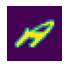

In [ ]:
a0 = stacked_a[0]
show_image(a0)

In [ ]:
dist_a_abs = (a0 - mean_a).abs().mean()
dist_a_rmse = ((a0 - mean_a)**2).mean().sqrt()
dist_a_abs, dist_a_rmse

(tensor(0.1174), tensor(0.2124))

In [ ]:
dist_b_abs = (a0 - mean_b).abs().mean()
dist_b_rmse = ((a0 - mean_b)**2).mean().sqrt()
dist_b_abs, dist_b_rmse

(tensor(0.1907), tensor(0.3152))

Using either of the above approaches, the average distance between the "a" example and the ideal "a" is less than that between the "b" example. Either can be used to classify. Defining a function for each might be the most convenient way to proceed.

In [ ]:
def abs_dist(ex, mean):
  return (ex - mean).abs().mean((-1, -2))

def rmse_dist(ex, mean):
  return ((ex - mean)**2).mean().sqrt()

abs_dist(a0, mean_b), rmse_dist(a0, mean_b)

(tensor(0.1907), tensor(0.3152))

Now the error between an example and the mean can be found easily. Defining a way to compare the error to other character is the next step.

The code below checks if the absolute mean error between an "a" example and the mean of "a" is less than that of a "b" example.

In [ ]:
abs_dist(a0, mean_a) < abs_dist(a0, mean_b)

tensor(True)

In [ ]:
def is_a(ex_a):
  return (abs_dist(ex_a, mean_a) < abs_dist(ex_a, mean_b)).float()

is_a(a0) 

tensor(1.)

### Create Validation Set
Gather validation data to measure accuracy of classification.

In [ ]:
valid_stacked_a = torch.stack([tensor(Image.open(x)) 
                              for x in a[65:128]]).float()/255
                              
valid_stacked_b = torch.stack([tensor(Image.open(x)) 
                              for x in b[65:128]]).float()/255

valid_stacked_a.shape, valid_stacked_b.shape

(torch.Size([63, 28, 28]), torch.Size([63, 28, 28]))

In [ ]:
accuracy_a =      is_a(valid_stacked_a) .mean()
accuracy_b = (1 - is_a(valid_stacked_b)).mean()

accuracy_a, accuracy_b

(tensor(0.9841), tensor(0.7937))

not accurate